Original by https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On

# Import

In [1]:
import lib.simulator as sim

from collections import namedtuple
import numpy as np
from random import random
import matplotlib.pyplot as plt
import lib.draw as draw
import pandas as pd
from tqdm import tqdm
from time import time
import os

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.ensemble import RandomForestRegressor

Loaded simulation models


# Define

In [2]:
# Define attempt and create directory to save progress
attempt = '1'
try:
    os.mkdir('img/decision_maps_' + attempt)
except:
    pass

In [3]:
# Noise for actions
MIN_PROB = 0.15
MAX_PROB = 1
NOISE_MEAN, NOISE_DEV = 0.0, 0.15

In [4]:
# Algo parameters
HIDDEN_SIZE = 128
BATCH_SIZE = 4096
PERCENTILE = 90
STOP_ITER = 100

# Initializations and functions

In [5]:
# Define supervised learning method
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, n_actions)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
# Create buffer auxiliars
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

In [7]:
# Limit probabilities to introduce noise
def into_probability_range(values):
    return_values = [max(min(value, MAX_PROB), MIN_PROB) for value in values]
    return_values = [value/sum(return_values) for value in return_values]

    return return_values

In [8]:
# Function that runs the agent on the environment to generate new data
def iterate_batches(net, batch_size, epsilon=0.8, epsilon_decay=0.98):
    batch_counter = 0
    goal_counter = 0
    batch = []
    episode_reward = 0.0
    episode_steps = []
    agent = sim.Agent(random(), random())
    while True:
        # Transform actions into performable actions for the environment
        if epsilon > random():
            ## Perform epsilon exploration
            if random() < 0.9:
                action = 1
            else:
                action = 0
            r = random()
            a = random()
        else:  
            ## Make prediction
            obs_v = torch.FloatTensor([[agent.x, agent.y]])
            act_v = net(obs_v)
            if agent.x > .50:
                act_prob_v = into_probability_range(act_v.data.numpy()[0][:2])
                if act_prob_v[0] > act_prob_v[1]:
                    action = 0
                else:
                    action = 1
            else:
                action = 1

            act_v = act_v.data.numpy()[0]
            r = act_v[2]
            a = act_v[3]

        # Perform action in the environment
        next_obs, reward, is_done, action_used = agent.do_action(action, r, a)

        # Register action feedback
        episode_reward += reward
        episode_steps.append(EpisodeStep(observation=[agent.x, agent.y], action=action_used))

        # If action is over
        if is_done:
            if agent.goal:
                goal_counter += 1
            batch.append(Episode(reward=episode_reward, steps=episode_steps))
            episode_reward = 0.0
            episode_steps = []

            # Return if batch size is big enough
            if len(batch) == batch_size:
                batch_counter += 1
                yield batch
                batch = []

            # Triangular distribution for less bias
            starting_x = np.random.triangular(0,0,1.3)
            while starting_x >= 1:
                starting_x = np.random.triangular(0,0,1.2)
            #if random() > 0.5:
            #    starting_y = np.random.triangular(0,0,0.7)
            #else:
            #    starting_y = np.random.triangular(0.3,1,1)
            starting_y = random()

            # Reset agent
            agent = sim.Agent(starting_x, starting_y)

            # Decrease epsilon
            epsilon *= epsilon_decay

obs_v = torch.FloatTensor([[.70, .50]])
act_v = net(obs_v)
act_v

In [9]:
# Function to test the agent
def deterministic_run(net, count=100, verbose=False):
    is_done = False
    rewards = []
    actions_made = []
    
    agent = sim.Agent(random(), random())
    # Run the agent 100 times
    for _ in range(count):
        agent.reset(random(), random())
        rewards_total = 0
        # Run agent till it stops
        while True:
            # Calculate and do action
            obs_v = torch.FloatTensor([[agent.x, agent.y]])
            act_v = net(obs_v)

            if agent.x > .50:
                action = np.argmax(act_v.data.numpy()[0][:2])
            else:
                action = 1

            act_v = act_v.data.numpy()[0]
            r = act_v[2]
            a = act_v[3]

            next_obs, reward, is_done, action_used = agent.do_action(action, r, a, verbose=verbose)

            rewards_total += reward
            actions_made.append(action)

            # If done proceed to next try
            if is_done:
                rewards.append(rewards_total)
                break
    return np.mean(rewards), actions_made

In [10]:
# Function filter best performing actions on the batch
def filter_batch(batch, percentile):
    # Calculate reward stats
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    # Separate data into lists
    train_obs = []
    train_act = []
    all_rewards = []
    all_acts = []
    for example in batch:
        all_acts.extend(map(lambda step: step.action, example.steps))
        if example.reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, example.steps))
        train_act.extend(map(lambda step: step.action, example.steps))
        while len(all_rewards) < len(train_obs):
            all_rewards.append(example.reward)

    # Transform in tensors and return
    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.FloatTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean, np.array(all_acts), all_rewards

# Run

In [11]:
# Define action spaces
obs_size = 2
n_actions = 4

In [12]:
# Initialize supervised learning method
net = Net(obs_size, HIDDEN_SIZE, n_actions)
objective = nn.MSELoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)

In [13]:
# Manually orienting network
## We want the starting actions to follow certain rules
### 1. Passes are relativelly short (r=0.2)
### 2. Angles are of 0 degrees (a=0.5)
### 3. Shot if inside the box
### 4. Pass if outside
df = pd.DataFrame([[i, j, 0.2, 0.5] for i in np.arange(0, 1.01, 0.01) for j in np.arange(0, 1, 0.015)], columns = ['x','y','r','a'])
df['Shot'] = ((df.x > .83) & (df.y > .25) & (df.y < .75))
df['Pass'] = ~df.Shot
df.Shot = df.Shot.astype(int)
df.Pass = df.Pass.astype(int)

# Train network with initial data
optimizer = optim.Adam(params=net.parameters(), lr=0.01)
for _ in tqdm(range(500)):
    optimizer.zero_grad()
    action_scores_v = net(torch.FloatTensor(df[['x', 'y']].to_numpy()))
    loss_v = objective(action_scores_v, torch.FloatTensor(df[['Shot', 'Pass', 'r', 'a']].to_numpy()))
    loss_v.backward()
    optimizer.step()

100%|██████████| 500/500 [00:23<00:00, 21.14it/s]


In [14]:
actions = []
scores = []
scores_bound = []
det_rewards = []
det_actions = []
t1 = time()

# Run main
for iter_no, batch in enumerate(iterate_batches(net, BATCH_SIZE)):
    # For every batch retrieve best instances
    obs_v, acts_v, reward_b, reward_m, all_acts, all_rewards = filter_batch(batch, PERCENTILE)

    # Train network
    for _ in range(500):
        optimizer.zero_grad()
        action_scores_v = net(obs_v)
        loss_v = objective(action_scores_v, acts_v)
        loss_v.backward()
        optimizer.step()

    # Saving data for analysis
    scores.append(reward_m)
    scores_bound.append(reward_b)
    actions.append(all_acts)

    det_reward, det_action = deterministic_run(net, verbose=False)
    det_rewards.append(det_reward)
    det_actions.append(det_action)

    pd.DataFrame(obs_v.cpu().detach().numpy(), columns=['x','y']).to_csv('tmp/debug_data_from_ce_traingularstart.csv')

    # Progress visualizer
    viz_df = pd.DataFrame([[i, j] for i in np.arange(0, 1.01, 0.01) for j in np.arange(0, 1, 0.015)], columns = ['x','y'])
    viz_df[['Shot', 'Pass', 'r', 'a']] = net(torch.FloatTensor(viz_df[['x','y']].to_numpy())).cpu().detach().numpy()
    viz_df['x'] *= 100
    viz_df['y'] *= 100

    ## Discrete action decisons
    draw.pitch()
    shot_action = viz_df[viz_df.Shot > viz_df.Pass]
    plt.scatter(shot_action.x, shot_action.y, s = 15, c = 'C0', alpha = 0.5, marker = 's', linewidth=0, zorder = 10);
    pass_action = viz_df[viz_df.Shot < viz_df.Pass]
    plt.scatter(pass_action.x, pass_action.y, s = 15, c = 'C1', alpha = 0.5, marker = 's', linewidth=0, zorder = 10);
    plt.savefig('img/decision_maps_' + attempt + '/passshotmap_' + str(iter_no) + '.png', dpi = 480)
    plt.clf()

    ## Continuous action decisions
    draw.pitch()
    for i, row in viz_df.iterrows():
        if i % 6 == 0:
            plt.arrow(row['x'], row['y'], row.r/abs(row.r) * np.cos((row['a'] - 0.5) * 2 * np.pi), row.r/abs(row.r) * np.sin((row['a'] - 0.5) * 2 * np.pi), length_includes_head = True, head_width = .5, head_length = .5, color = 'white', zorder = 100)
    viz_df['i'] = [i for i in range(len(viz_df))]
    plt.scatter(viz_df[(viz_df.i % 6) == 0].x, viz_df[(viz_df.i % 6) == 0].y, s=(viz_df[(viz_df.i % 6) == 0].r + 1) ** 2, zorder = 99)
    plt.savefig('img/decision_maps_' + attempt + '/orientationmap_' + str(iter_no) + '.png', dpi = 480)
    plt.clf()

    # Output log
    print(str(iter_no).ljust(5), "loss=%.2f".ljust(12) % loss_v.item(), "rewards=%.4f".ljust(15) % (reward_m), "rwrd_bound=%.4f".ljust(12) % reward_b, "det_rewards=%.4f".ljust(15) % (det_reward), "time=%d".ljust(15) % (time() - t1))

    # Stop if iteration limit is achieved
    if iter_no > STOP_ITER:
        print("End")
        break

0     loss=0.05    rewards=0.0012    rwrd_bound=0.0068 det_rewards=-0.0380 time=12        
1     loss=0.00    rewards=-0.0236    rwrd_bound=0.0043 det_rewards=-0.0310 time=25        
2     loss=0.00    rewards=-0.0260    rwrd_bound=0.0042 det_rewards=-0.0434 time=38        
3     loss=0.00    rewards=-0.0236    rwrd_bound=0.0044 det_rewards=-0.0404 time=51        
4     loss=0.00    rewards=-0.0246    rwrd_bound=0.0043 det_rewards=-0.0319 time=64        
5     loss=0.00    rewards=-0.0256    rwrd_bound=0.0042 det_rewards=-0.0338 time=76        
6     loss=0.00    rewards=-0.0258    rwrd_bound=0.0042 det_rewards=-0.0354 time=89        
7     loss=0.00    rewards=-0.0235    rwrd_bound=0.0041 det_rewards=-0.0419 time=100        
8     loss=0.00    rewards=-0.0247    rwrd_bound=0.0041 det_rewards=-0.0322 time=112        
9     loss=0.00    rewards=-0.0238    rwrd_bound=0.0042 det_rewards=-0.0363 time=122        
10    loss=0.00    rewards=-0.0287    rwrd_bound=0.0041 det_rewards=-0.0411 ti

# Information about the run

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


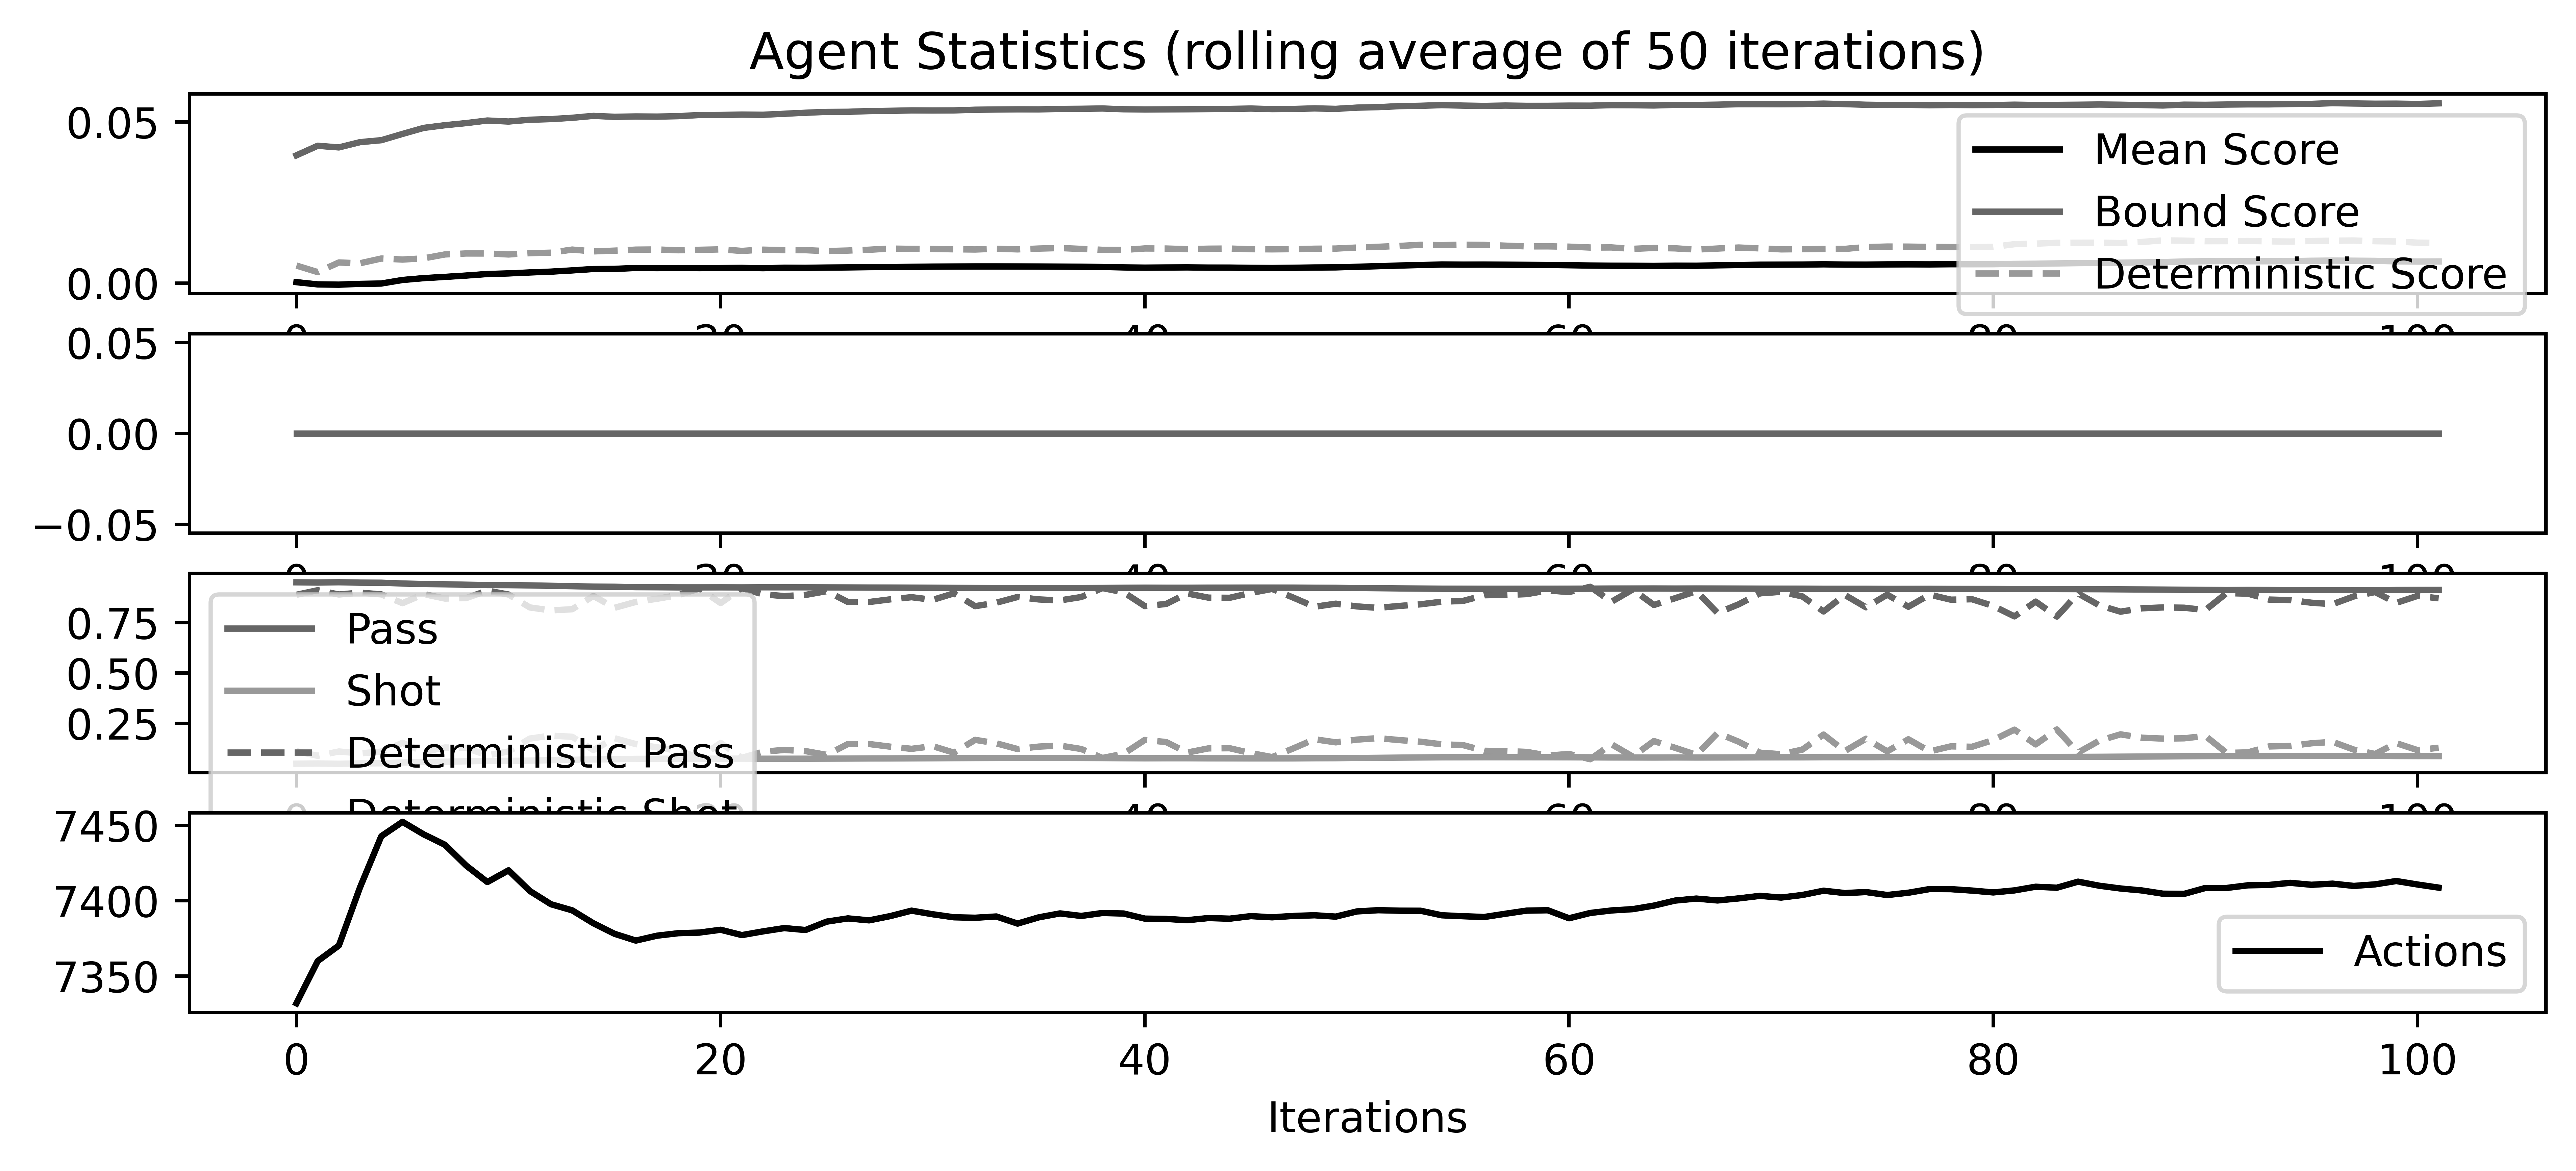

In [15]:
# Code to visualize action evolution
plt.style.use('grayscale')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 900
plt.rcParams['figure.figsize'] = (10,4)

rolling_size = 50

to_print = pd.DataFrame(columns = ['Score', 'BouScore', 'DetScore', 'Noise', 'Shot', 'Pass', 'Actions', 'DetShot', 'DetPass', 'DetActions'])
for i, acts in enumerate(actions):
    to_print.loc[len(to_print)] = [scores[i], scores_bound[i], det_rewards[i], 0, acts[:,0].mean(), acts[:,1].mean(), len(acts), det_actions[i].count(0), det_actions[i].count(1), len(det_actions[i])]

plt.subplot(4,1,1)
plt.title('Agent Statistics (rolling average of 50 iterations)')
plt.plot(to_print['Score'].rolling(rolling_size, min_periods=0).mean(), color = 'C0', label = 'Mean Score')
plt.plot(to_print['BouScore'].rolling(rolling_size, min_periods=0).mean(), color = 'C5', label = 'Bound Score')
plt.plot(to_print['DetScore'].rolling(rolling_size, min_periods=0).mean(), linestyle = '--', color = 'C6', label = 'Deterministic Score')
plt.legend()

plt.subplot(4,1,2)
plt.plot(to_print['Noise'], color = 'C5', label = 'Score')

plt.subplot(4,1,3)
plt.plot(to_print['Pass'].rolling(rolling_size, min_periods=0).mean(), color = 'C1', label = 'Pass')
plt.plot(to_print['Shot'].rolling(rolling_size, min_periods=0).mean(), color = 'C2', label = 'Shot')
plt.plot(to_print['DetPass']/to_print['DetActions'], linestyle = '--', color = 'C1', label = 'Deterministic Pass')
plt.plot(to_print['DetShot']/to_print['DetActions'], linestyle = '--', color = 'C2', label = 'Deterministic Shot')
plt.legend()

plt.subplot(4,1,4)
plt.plot(to_print['Actions'].rolling(rolling_size, min_periods=0).mean(), color = 'C4', label = 'Actions')
plt.xlabel('Iterations')
plt.legend()


plt.savefig('img/paper imgs/agent_stats.png', format='png')
plt.savefig('img/paper imgs/agent_stats.eps', format='eps');

In [16]:
# Create visualization data frame
viz_df = pd.DataFrame([[i, j] for i in np.arange(0, 1.01, 0.01) for j in np.arange(0, 1, 0.015)], columns = ['x','y'])

viz_df[['Shot', 'Pass', 'r', 'a']] = net(torch.FloatTensor(viz_df[['x','y']].to_numpy())).cpu().detach().numpy()

viz_df['x'] *= 100
viz_df['y'] *= 100

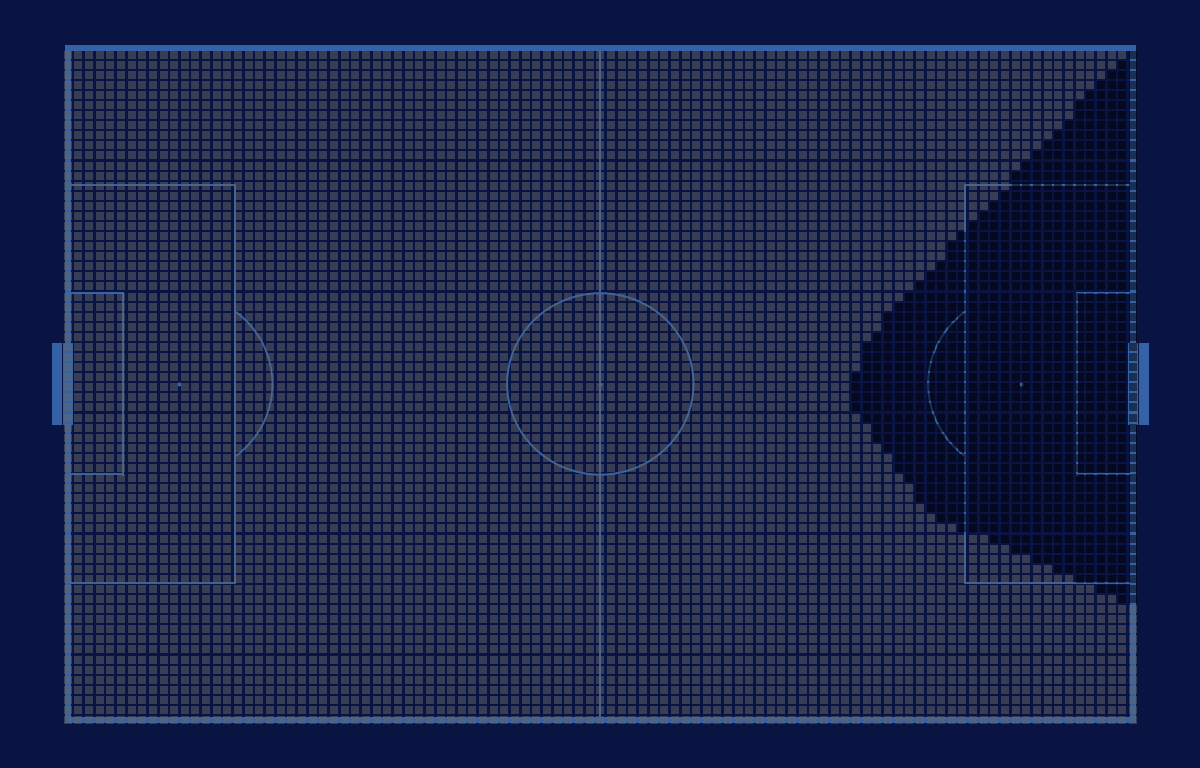

In [17]:
# Plot action distribution
draw.pitch()
shot_action = viz_df[viz_df.Shot > viz_df.Pass]
plt.scatter(shot_action.x, shot_action.y, s = 15, c = 'C0', alpha = 0.5, marker = 's', linewidth=0, zorder = 10);
pass_action = viz_df[viz_df.Shot < viz_df.Pass]
plt.scatter(pass_action.x, pass_action.y, s = 15, c = 'C1', alpha = 0.5, marker = 's', linewidth=0, zorder = 10);

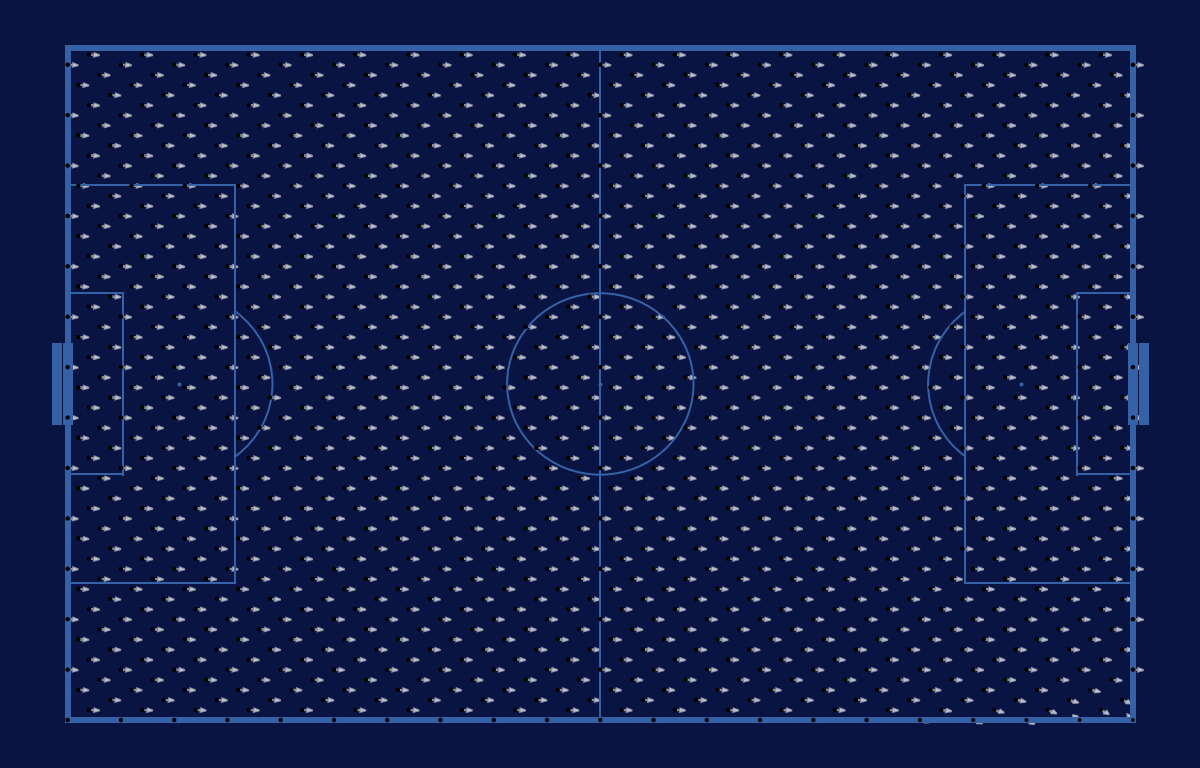

In [18]:
# Plot directions
draw.pitch()
for i, row in viz_df.iterrows():
    if i % 5 == 0:
        plt.arrow(row['x'], row['y'], row.r/abs(row.r) * np.cos((row['a'] - 0.5) * 2 * np.pi), row.r/abs(row.r) * np.sin((row['a'] - 0.5) * 2 * np.pi), alpha = 0.5, length_includes_head = True, head_width = .5, head_length = .5, color = 'white')
viz_df['i'] = [i for i in range(len(viz_df))]
plt.scatter(viz_df[(viz_df.i % 5) == 0].x, viz_df[(viz_df.i % 5) == 0].y, s=(viz_df[(viz_df.i % 5) == 0].r + 1) ** 2, zorder = 99)